# Initalization

Many of these sections were heavily inspired by Sam Zorowitz. Modeled after analysis found here: https://github.com/mghneurotherapeutics/JNeurosci-ARC/blob/master/ARC_Analysis_FINAL.ipynb


In [1]:
import sys
sys.path.append('../src')
from fmri import generate_task_regressors, plot_task_regressors
from utils import select_subjects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# fmri timing info 
tr = 1.75
num_acq = 228
dt = .001 # upsampled regressor resolution

# Pick fmri subjects
subjects = select_subjects('fmri')

# folders
fsfast_path = '../data/derivatives/fmri_first_levels'
fmriprep_path = '../data/derivatives/fmriprep'

# Load behavior data
behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv', 
                       sep='\t')
behavior = behavior[behavior.modality == 'fmri']

# remove excluded trials 
exclusions = ['error', 'post_error', 'no_response', 'fast_rt']
behavior = behavior[behavior[exclusions].sum(axis=1) == 0]

# First Levels

## Make Task Paradigm Files 

Here I make regressors for the congruent and incongruent conditions. I make both full duration boxcar regressors and variable rt epoch regressors to look at RT independent and dependent effects. Methods and considerations based on the following papers:

- Tal Yarkoni's Blog Post on time on task implications: https://www.talyarkoni.org/blog/2010/06/16/time-on-task-effects-in-fmri-research-why-you-should-care/
- Yarkoni paper related to above blog post: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2622763/
- Grinbad Paper explaining variable RT epoch method as most ideal method for accounting for time on task effects: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2654219/

Note that the variable RT epoch model assumes the process is well approximated by a diffusion model.

In [6]:
for subject in subjects:
    print(subject)
    
    sub_behavior = behavior[behavior.participant_id == subject]
    sub_behavior['tt'] = sub_behavior.trial_type.astype('category').cat.codes
    sub_behavior['weight'] = 1.0
    
    # extract behavior information
    for typ in ['base', 'rt']:
        if typ == 'base':
            columns = ['onset', 'tt', 'duration', 'weight', 'trial_type']
        else:
            columns = ['onset', 'tt', 'response_time', 'weight', 'trial_type']
        
        df = sub_behavior[columns]
        
        # save the regressors
        f = '%s/%s/msit/001/%s.par'
        df.to_csv(f % (fsfast_path, subject, typ), header=False, sep='\t',
                  index=False)
        
        
print('Done!') 

sub-hc001
sub-hc002
sub-hc003


/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


sub-hc004
sub-hc005
sub-hc006
sub-hc007
sub-hc008
sub-hc009
sub-hc010
sub-hc011
sub-hc012
sub-hc013
sub-hc014
sub-hc015
sub-hc016
sub-hc017
sub-hc019
sub-hc021
sub-hc022
sub-hc023
sub-hc024
sub-hc025
sub-hc026
sub-hc027
sub-hc028
sub-hc029
sub-hc030
sub-hc031
sub-hc032
sub-hc033
sub-hc034
sub-hc035
sub-hc036
sub-hc038
sub-hc041
sub-hc042
sub-hc044
sub-pp001
sub-pp002
sub-pp003
sub-pp004
sub-pp005
sub-pp006
sub-pp007
sub-pp008
sub-pp009
sub-pp010
sub-pp011
sub-pp012
sub-pp013
sub-pp014
sub-pp015
sub-pp016
Done!


## Make Motion Timepoint Censors

We use only functional displacement based motion timepoint censoring (and no motion regressors) as determined in <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3895106/"> Siegel 2013 </a>. We use their threshold of 0.9 mm though we recognize this was not a global recommendation, but it is used here as a reasonable value without further investigation.

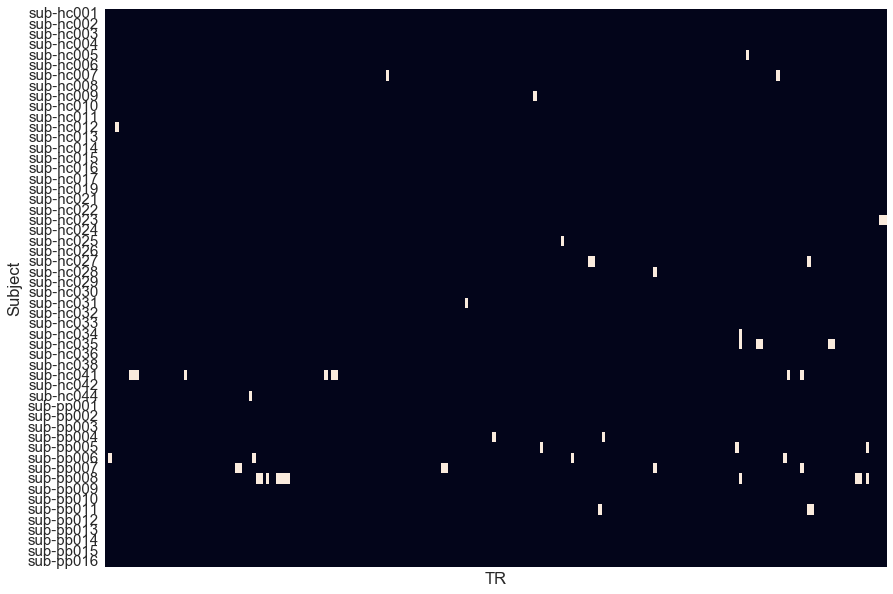

In [3]:
fd = 0.9
fds = np.zeros((len(subjects), num_acq))

for i, subject in enumerate(subjects):
    
    f = '%s/%s/func/%s_task-msit_bold_confounds.tsv'
    confounds = pd.read_csv(f % (fmriprep_path, subject, subject),
                            sep='\t', na_values='n/a')
    
    # determine fd censor indices 
    fd_ix = np.where(confounds.FramewiseDisplacement >= fd)[0]
    fds[i, fd_ix] = 1
    
    # save censor indices
    f = '%s/%s/msit/001/fd_censor.par' 
    np.savetxt(f % (fsfast_path, subject), fd_ix, fmt='%d')
        
# Plot censor heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(fds, cbar=False)
plt.xticks(())
plt.yticks(np.arange(len(subjects)) + .5, subjects, rotation=0)
plt.xlabel('TR')
plt.ylabel('Subject')
plt.show()

## Run 1st Levels

## Visualize Design Matrix